### 목적

TFrecord파일에 대해 데이터와 라벨을 한 파일에 넣음으로써 따로따로 접근하는 시간을 줄여주기 때문에 bottleneck을 없애준다고들 합니다. 이게 그냥 raw데이터파일에서 bytes단위로 끊어서 읽는 것과 정확히 어떤 차이가 있는지는 모르겠습니다.<br>
제가 TFrecord파일을 쓰려는 목적은 어차피 특별한 기술이 들어가지 않는 raw data 쓸거 차라리 tensorflow와 친화적으로 설계되었을 것으로 예상되는 TFrecord를 쓰려는 것입니다. 나름 공식 API니 알아서 잘설계해놨을 것으로 기대합니다!

### 1.시작 - 데이터셋 확인

처음 다뤄보는 데이터 파일이니 먼저 읽어서 잘나오는지부터 확인합니다.

각자의 방식으로 저장 된 데이터셋들 제대로 parsing했는지 이미지출력해서 확인해보기

In [65]:
import numpy as np
import matplotlib.pyplot as plt
def load_dataset_as_numpy(filename):
    print("We will load a file named (",filename,")")
    amat_file=open(filename, "r")
    str_data=amat_file.readlines()  
    # 각 줄을 string으로 읽어서 list로 만들어 반환합니다.
    # 즉 [line1, line2, line3, ...] 형태입니다.
    str_data_splited=[x.split() for x in str_data] 
    # space로 각 float number가 분리되어 있습니다, 그걸 space기준으로 나눕니다.
    float_data_splited=[[float(x) for x in xx] for xx in str_data_splited]
    # 여기서 사용한 데이터셋은 한 줄에 785개의 숫자가 있습니다,784개는 픽셀 데이터
    # 마지막 한개는 label데이터입니다.
    data=np.array(float_data_splited)
    # slicing하기도 편하고 익숙한 numpy로 바꿔줍니다.
    # 어차피 데이터셋 한번 만들고 안쓸 코드니 효율은 뒤로하겠습니다..
    images=data[:,0:-1]
    labels=data[:,-1]
    print("Images loaded, shape=",images.shape)
    print("labels loaded: shape=",labels.shape)
    return images,labels.astype(dtype=np.int32)
# 위에서는 모든 데이터를 메모리에 올리는데 이는 데이터가 6만개라 가능합니다.
# 만약 600만개인데 전부 메모리에 올리는 것보다는 한번에 일부만 여러번 읽는게 합리적입니다.

def plot_images(rows,cols,images,labels):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, ax in enumerate(axes.flat):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[i,:,:,0],cmap='gray')
        ax.set_xlabel(str(labels[i]))
    

### MNIST_back 

In [61]:
%matplotlib inline
images_train,labels_train=load_dataset_as_numpy("./MNIST_back/mnist_background_images_train.amat")
images_test, labels_test =load_dataset_as_numpy("./MNIST_back/mnist_background_images_test.amat")
images_train=images_train.reshape([12000,28,28,1])
images_test=images_test.reshape([50000,28,28,1])
# 이 데이터 셋을 그냥 reshape해서 출력해보면 뒤집힌 모양이 나오네요
images_train_upright=images_train.swapaxes(1,2).astype(np.float32)
images_test_upright=images_test.swapaxes(1,2).astype(np.float32)
# 원래 의도한 대로 똑바로 선 숫자로 만들기 위해 transpose를 해줍니다.

We will load a file named ( ./MNIST_back/mnist_background_images_train.amat )
Images loaded, shape= (12000, 784)
labels loaded: shape= (12000,)
We will load a file named ( ./MNIST_back/mnist_background_images_test.amat )
Images loaded, shape= (50000, 784)
labels loaded: shape= (50000,)


(12000, 28, 28, 1)


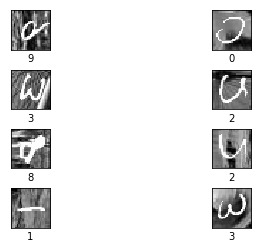

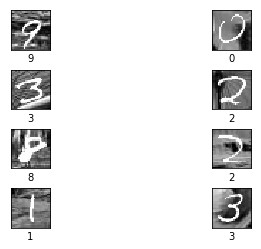

In [66]:
#print("transpose 하기 전")
print(images_train.shape)
plot_images(4,2,images_train,labels_train)
#print("transpose 한 후")
plot_images(4,2,images_train_upright,labels_train)

### MNIST dataset 

In [68]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST", one_hot=False)
images_train_ori= mnist.train.images.reshape([55000,28,28,1])
labels_train_ori= mnist.train.labels
images_test_ori = mnist.test.images.reshape([10000,28,28,1])
labels_test_ori = mnist.test.labels

Extracting ./MNIST\train-images-idx3-ubyte.gz
Extracting ./MNIST\train-labels-idx1-ubyte.gz
Extracting ./MNIST\t10k-images-idx3-ubyte.gz
Extracting ./MNIST\t10k-labels-idx1-ubyte.gz


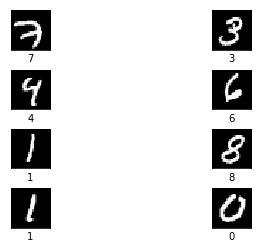

In [69]:
plot_images(4,2,images_train_ori,labels_train_ori)

In [24]:
# Let's convert the picture into string representation
# using the ndarray.tostring() function 
image_string = images[rand_integer,:,:].tostring()
# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_cat_1d = np.frombuffer(image_string, dtype=np.float32)
# print(reconstructed_cat_1d)
# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_cat_img = reconstructed_cat_1d.reshape([28,28])

# Let's check if we got everything right and compare
# reconstructed array to the original one.
np.allclose(images[rand_integer,:,:], reconstructed_cat_img)

NameError: name 'images' is not defined

### Creating a _.tfrecord_ file and reading it without defining a graph

In [75]:
%matplotlib inline
# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
# import skimage.io as io
import tensorflow as tf
def wrap_bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def wrap_int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def write_tfrecord(images,labels,filename):
    writer = tf.python_io.TFRecordWriter(filename)
    original_images = []
    for i in range(labels.shape[0]):
        img=images[i,:,:]
        label=int(labels[i])
        # Put in the original images into array, Just for future check for correctness
        original_images.append((img, label))
#         height = img.shape[0]
#         width = img.shape[1]
        img_raw = img.tostring()
#         print(img.dtype)
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': wrap_bytes_feature(img_raw),
            'label': wrap_int64_feature(label)}))
        writer.write(example.SerializeToString())
    writer.close()
    print("Data is writed to (%s) successfully!"%filename)
    return original_images

In [76]:
original_images_train=write_tfrecord(images_train_upright,labels_train,
                                     "./MNIST_back_train.tfrecord")
original_images_test=write_tfrecord(images_test_upright,labels_test,
                                    "./MNIST_back_test.tfrecord")
original_images_train=write_tfrecord(images_train_ori,labels_train_ori,
                                     "./MNIST_ori_train.tfrecord")
original_images_test=write_tfrecord(images_test_ori,labels_test_ori,
                                    "./MNIST_ori_test.tfrecord")

Data is writed to (./MNIST_back_train.tfrecord) successfully!
Data is writed to (./MNIST_back_test.tfrecord) successfully!
Data is writed to (./MNIST_ori_train.tfrecord) successfully!
Data is writed to (./MNIST_ori_test.tfrecord) successfully!


In [34]:
def read_tfrecord(tfrecords_filename):
    reconstructed_images = []
    record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
    for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)
        img_string = (example.features.feature['image_raw']
                                      .bytes_list
                                      .value[0])
        label = int(example.features.feature['label']
                                    .int64_list
                                    .value[0])
        img_1d = np.frombuffer(img_string, dtype=np.float32)
        reconstructed_img = img_1d.reshape((28, 28))
        # Annotations don't have depth (3rd dimension)
        reconstructed_images.append((reconstructed_img, label))
    return reconstructed_images
reconstructed_images_train=read_tfrecord("./MNIST_back_train.tfrecord")
reconstructed_images_test=read_tfrecord("./MNIST_back_test.tfrecord")

In [101]:
# Let's check if the reconstructed images match
# the original images
def compare_data(original_images,reconstructed_images):
    val=0
    for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
        img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,reconstructed_pair)
        val+=np.allclose(*img_pair_to_compare)+np.allclose(*annotation_pair_to_compare)
        #이미지 한번, 라벨 한번 비교함.
    if val==2*len(original_images):
        print("The TFrecord file you make is perfect")
    else:
        print("Some errors occured, val=",val)
compare_data(original_images_train,reconstructed_images_train)
compare_data(original_images_test,reconstructed_images_test)

The TFrecord file you make is perfect
The TFrecord file you make is perfect


### Defining the graph to read and batch images from _.tfrecords_

Here we define a graph to read and batch images from the file that we have created
previously. It is very important to randomly shuffle images during training and depending
on the application we have to use different batch size.

It is very important to point out that if we use batching -- we have to define
the sizes of images beforehand. This may sound like a limitation, but actually in the
Image Classification and Image Segmentation fields the training is performed on the images
of the same size. 

The code provided here is partially based on [this official example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py) and code from [this stackoverflow question](http://stackoverflow.com/questions/35028173/how-to-read-images-with-different-size-in-a-tfrecord-file).
Also if you want to know how you can control the batching according to your need read [these docs](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard2/tf.train.shuffle_batch.md)
.

In [14]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

def read_and_decode(serialized):
    features = tf.parse_single_example(
      serialized,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
        })
    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [28, 28])
    return image, label

In [16]:
# The op for initializing the variables.
dataset = tf.data.TFRecordDataset(filenames=['./MNIST_back_train.tfrecords'])
dataset = dataset.map(read_and_decode)
dataset = dataset.shuffle(buffer_size=256)
dataset = dataset.repeat()
dataset = dataset.batch(2)
iterator = dataset.make_one_shot_iterator()#     print(sess.run(images_batch))
print(iterator.output_types,iterator.output_shapes)
# coord = tf.train.Coordinator()
# threads = tf.train.start_queue_runners(coord=coord)
    
# #     # Let's read off 3 batches just for example
# #     for i in range(3):
# #         img, anno = sess.run([images_batch, labels_batch])
# #         print(img[0, :, :].shape)
# #         print('current batch')
        
# #         # We selected the batch size of two
# #         # So we should get two image pairs in each batch
# #         # Let's make sure it is random

# #         io.imshow(img[0, :, :])
# #         io.show()

# #         io.imshow(anno[0])
# #         io.show()
        
# #         io.imshow(img[1, :, :])
# #         io.show()

# #         io.imshow(anno[1])
# #         io.show()
        
    
# #     coord.request_stop()
# #     coord.join(threads)


(tf.float32, tf.int32) (TensorShape([Dimension(None), Dimension(28), Dimension(28)]), TensorShape([Dimension(None)]))


In [17]:
images_batch, labels_batch = iterator.get_next()
print(images_batch)
print(labels_batch)


Tensor("IteratorGetNext_1:0", shape=(?, 28, 28), dtype=float32)
Tensor("IteratorGetNext_1:1", shape=(?,), dtype=int32)


In [ ]:
sess=tf.InteractiveSession()
sess.run(images_batch)

### Conclusion and Discussion

In this post we covered how to convert a dataset into _.tfrecord_ format,
made sure that we have the same data and saw how to define a graph to
read and batch files from the created file.

In [3]:
import iris_data

# Fetch the data
train, test = iris_data.load_data()
features, labels = train

8192/2194 [================================================================================================================]8192/2194 [================================================================================================================] - 0s 0us/step

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================]8192/573 [===============================================================================================================================================================================================================================================================================================

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(dict(features))
display(dataset)

<TensorSliceDataset shapes: {SepalLength: (), SepalWidth: (), PetalLength: (), PetalWidth: ()}, types: {SepalLength: tf.float64, SepalWidth: tf.float64, PetalLength: tf.float64, PetalWidth: tf.float64}>

In [8]:
batch_size=100
iris_data.train_input_fn(features, labels, batch_size)

<BatchDataset shapes: ({SepalLength: (?,), PetalLength: (?,), SepalWidth: (?,), PetalWidth: (?,)}, (?,)), types: ({SepalLength: tf.float64, SepalWidth: tf.float64, PetalLength: tf.float64, PetalWidth: tf.float64}, tf.int64)>

In [80]:
[1,2].mul()

AttributeError: 'list' object has no attribute 'mul'